<a href="https://colab.research.google.com/github/Fieehm/Workshop-Astra-Financial/blob/main/Workshop_(python)_Tahap_1%2C2%263_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Tahap I** _Pre Processing_

Pada tahap ini, kita akan _import_ semua data transaksi bulanan (format `.csv`) ke dalam _computing environment_).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import re
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_1 = pd.read_csv('jan 2020.csv')
df_2 = pd.read_csv('feb 2020.csv')
df_3 = pd.read_csv('mar 2020.csv')
df_4 = pd.read_csv('apr 2020.csv')

df_all = pd.concat([df_1, df_2, df_3, df_4], axis=0) # Penggabungan data frame menggunakan pandas
df_all = df_all.drop('id', axis=1) # Menghapus kolom id
df_all['tanggal'] = pd.to_datetime(df_all['tanggal']) # Mengubah kolom tanggal menjadi data tipe date
df_all['bulan'] = df_all['tanggal'].dt.strftime('%B') # Menambahkan kolom bulan dengan tanggal sebagai acuan bulan
df_all = df_all.sort_values(by='tanggal').reset_index(drop=True) # Mengurutkan data berdasarkan tanggal
df_all = df_all[['id_transaksi','tanggal','bulan','hari','jam','ampm','id_pelanggan','sku','qty','unit','harga','diskon','total_harga']] #Mengatur ulang kolom dalam data frame

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34436 entries, 0 to 34435
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id_transaksi  34436 non-null  object        
 1   tanggal       34436 non-null  datetime64[ns]
 2   bulan         34436 non-null  object        
 3   hari          34436 non-null  object        
 4   jam           34436 non-null  int64         
 5   ampm          34436 non-null  object        
 6   id_pelanggan  34436 non-null  object        
 7   sku           34436 non-null  object        
 8   qty           34436 non-null  int64         
 9   unit          34436 non-null  object        
 10  harga         34436 non-null  float64       
 11  diskon        34436 non-null  float64       
 12  total_harga   34436 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 3.4+ MB


Berikut adalah penjelasan beberapa variabel dari data yang sudah digabung:

- `id_transaksi`: __id__ dari satu transaksi.
- `tanggal`: tanggal transaksi.
- `id_pelanggan`: merupakan __id__ pelanggan. Pelanggan yang menjadi _member_ akan ditulis nomor _membership_-nya. Sedangkan pelanggan yang _non member_ ditulis sebagai __UMUM__.
- `sku`: merupakan nama produk yang dibeli.
- `diskon`: merupakan diskon produk dalam __persentase__.
- `total_harga`: merupakan harga total per `sku` yang merupakan perkalian dari `qty` dengan `harga` setelah dikurang `diskon`.

## **Tahap II** _Exploratory Data Analysis_

Sekarang kita akan buat EDA sederhana dari data gabungan yang ada.

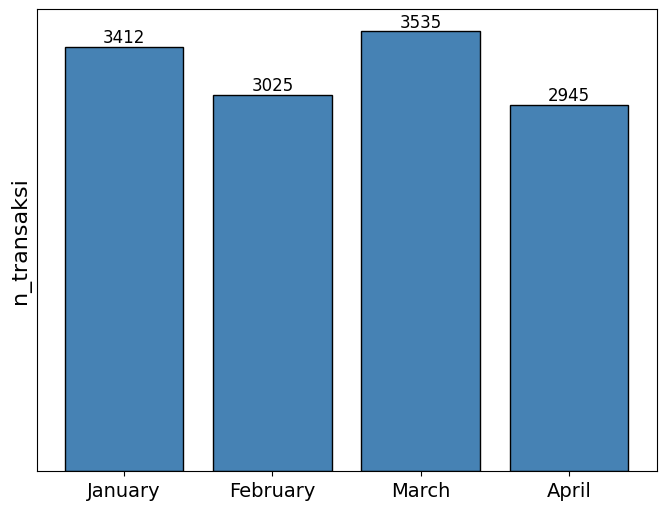

In [ ]:
month_order = ["January", "February", "March", "April"] # Urutan bulan untuk sorting data frame


n_trans = df_all.groupby('bulan')['id_transaksi'].nunique().reset_index()
n_trans['bulan'] = pd.Categorical(n_trans['bulan'], categories=month_order, ordered=True)
n_trans = n_trans.sort_values('bulan')

plt.figure(figsize=(8,6))
bars = plt.bar(n_trans['bulan'], n_trans['id_transaksi'], color='steelblue', edgecolor='black')
plt.ylabel("n_transaksi", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks([])
for bar, label in zip(bars, n_trans['id_transaksi']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{label}', ha='center', va='bottom', fontsize=12)
plt.show()

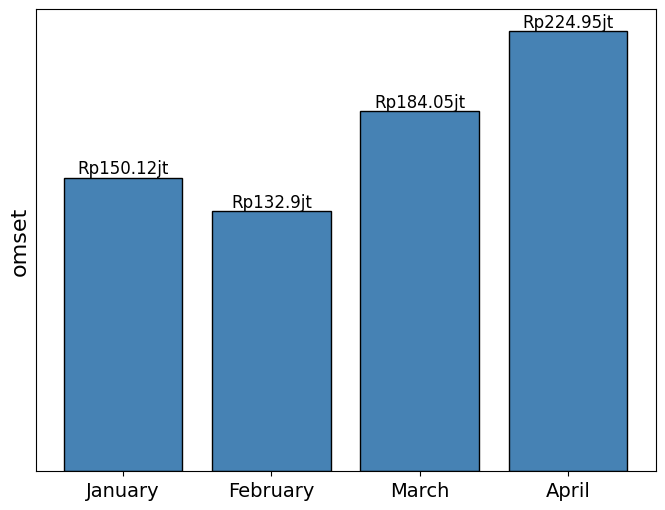

In [ ]:
df_omset = df_all.groupby('bulan').agg(omset = ('total_harga', 'sum')).reset_index()
df_omset['bulan'] = pd.Categorical(df_omset['bulan'], categories=month_order, ordered=True)
df_omset = df_omset.sort_values('bulan')
df_omset['xlabel'] = (df_omset['omset']/1000000).round(2)
df_omset ['xlabel']= "Rp" + df_omset['xlabel'].astype(str) + "jt"

plt.figure(figsize=(8,6))
bar = plt.bar(df_omset['bulan'], df_omset['omset'], color='steelblue', edgecolor='black')
plt.ylabel("omset", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks([])
for bar, label in zip(bar, df_omset['xlabel']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label, ha='center', va='bottom', fontsize=12)
plt.show()

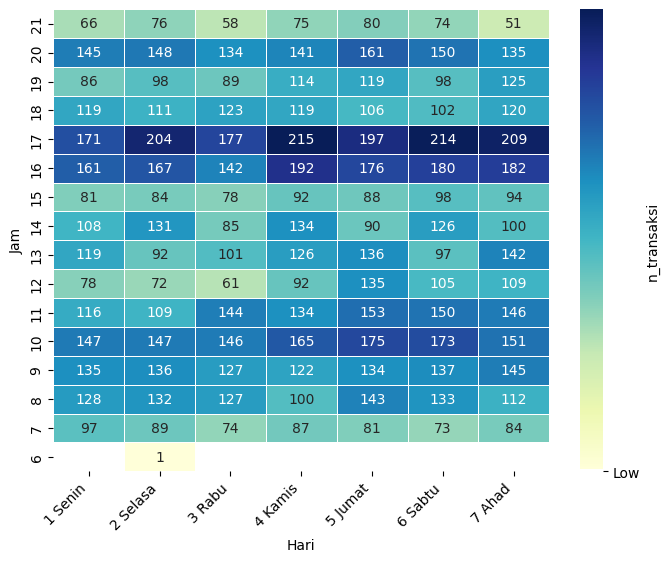

In [ ]:
df_waktu = (df_all.groupby(['hari', 'jam'], as_index=False).agg(frekuensi=('id_transaksi', 'nunique')))
df_waktu = df_waktu.pivot(index='jam', columns='hari', values='frekuensi')

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df_waktu, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'n_transaksi'}, linewidths=0.5)

cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, df_waktu.values.max()])
cbar.set_ticklabels(['Low', 'High'])
plt.gca().invert_yaxis()
plt.xlabel("Hari")
plt.ylabel("Jam")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Selain tiga grafik di atas, EDA apa lagi yang bisa kita lakukan? Silakan buat sebagai bahan latihan.

## **Tahap III** _Clustering Analysis_ berdasarkan RFM

Pada analisa ini, __kita hanya akan memakai data transaksi dari pelanggan yang menjadi__ ___member___. Sehingga akan ada proses _filtering_ data.

__Definisi:__

- _Retention_ adalah kapan terakhir kali pelanggan bertransaksi pada rentang Januari 2020 sampai April 2020.
- _Frequency_ adalah berapa kali pelanggan bertransaksi pada rentang Januari 2020 sampai April 2020.
- _Monetary_ adalah seberapa besar (secara _value_ rupiah) pelanggan berbelanja pada rentang Januari 2020 sampai April 2020.

Kita akan menghitung ketiga parameter tersebut dengan aturan sebagai berikut:

1. Semua parameter memiliki nilai skala 1-4 (paling rendah ke paling tinggi).
1. _Retention_: pelanggan yang terakhir kali membeli pada:
    - _April_ mendapat skor 4.
    - _March_ mendapat skor 3.
    - _February_ mendapat skor 2.
    - _January_ mendapat skor 1.
1. _Frequency_: kita akan hitung rata-rata transaksi bulanan untuk setiap pelanggan. Kemudian dari semua data yang ada, kita akan bagi menjadi __empat__ kelompok berdasarkan _range_ datanya.
1. Monetary: Kita akan hitung rata-rata belanja bulanan untuk setiap pelanggan. Kemudian dari semua data yang ada, kita akan bagi menjadi __empat__ kelompok berdasarkan _range_ datanya.

In [ ]:
df_all.head()

,id_transaksi,tanggal,bulan,hari,jam,ampm,id_pelanggan,sku,qty,unit,harga,diskon,total_harga
0,00001/KSR/UTM/0120,2020-01-02,January,4 Kamis,8,1 pagi,UMUM,KOPIKO COFFE LATTE 240 ML,1,PCS,5400.0,0.0,5400.0
1,00072/KSR/UTM/0120,2020-01-02,January,4 Kamis,13,2 siang,UMUM,GAS 3KG,1,PCS,20000.0,0.0,20000.0
2,00147/KSR/UTM/0120,2020-01-02,January,4 Kamis,18,3 sore,UMUM,QTELA SINGKONG BALADO 185GR,1,PCS,14200.0,0.0,14200.0
3,00147/KSR/UTM/0120,2020-01-02,January,4 Kamis,18,3 sore,UMUM,HYDRO COCO ORIGINAL PET 500ML,1,PCS,11000.0,0.0,11000.0
4,00147/KSR/UTM/0120,2020-01-02,January,4 Kamis,18,3 sore,UMUM,HYDRO COCO ORIGINAL 250 NL,1,PCS,6000.0,0.0,6000.0


In [ ]:
# mengambil data yang khusus untuk RFM
# Memfilter data df_all untuk hanya menyertakan pelanggan yang merupakan member (id_pelanggan != "UMUM")
df_rfm = df_all[df_all['id_pelanggan'] !='UMUM']

# perhitungan retention
# Menghitung skor retention berdasarkan bulan terakhir transaksi

df_rfm_1 = df_rfm
# Membuat kolom baru 'retention' dengan skor 1-4 berdasarkan bulan transaksi
df_rfm_1['retention'] = df_rfm_1['bulan'].apply(lambda x: 1 if x == 'January' else  # Jika bulan transaksi Januari, skor retention = 1
                                                          2 if x == 'February' else # Jika bulan transaksi Februari, skor retention = 2
                                                          3 if x == 'March' else # Jika bulan transaksi Maret, skor retention = 3
                                                          4 if x == 'April' else None)# Jika bulan transaksi April, skor retention = 4

# Menghapus baris duplikat berdasarkan kombinasi id_pelanggan dan retention
df_rfm_1 = df_rfm_1[['id_pelanggan', 'retention']].drop_duplicates()
# Mengelompokkan data berdasarkan id_pelanggan dan Memfilter data untuk setiap pelanggan, hanya mempertahankan baris dengan skor retention tertinggi
df_rfm_1 = df_rfm_1.loc[df_rfm_1.groupby('id_pelanggan')['retention'].idxmax()]

# perhitungan frekuensi
# Menghitung frekuensi transaksi per pelanggan
# Mengelompokan berdasarkan id_pelanggan dan menghitum jumlah transaksi unik untuk disimpan pada kolom 'freq'
df_rfm_2 = df_rfm.groupby('id_pelanggan').agg(freq=('id_transaksi', 'nunique')).reset_index()
# Menghitung rata-rata frekuensi transaksi bulanan dengan membagi 'freq' dengan 4 (jumlah bulan)
df_rfm_2['freq'] = df_rfm_2['freq'] / 4
df_rfm_2['freq'] = pd.cut(df_rfm_2['freq'], bins=4, labels=[1, 2, 3, 4]).astype(int)

# perhitungan monetary
# Menghitung total nilai transaksi (monetary) per pelanggan
# Mengelompokkan data berdasarkan id_pelanggan dan menghitung total nilai transaksi per pelanggan dan menyimpannya di kolom 'monetary'
df_rfm_3 = df_rfm.groupby('id_pelanggan').agg(monetary=('total_harga', 'sum')).reset_index()
# Menghitung rata-rata nilai transaksi bulanan dengan membagi 'monetary' dengan 4 (jumlah bulan)
df_rfm_3['monetary'] = df_rfm_3['monetary'] / 4
df_rfm_3['monetary'] = pd.cut(df_rfm_3['monetary'], bins=4, labels=[1, 2, 3, 4]).astype(int)

# Menggabungkan data frame df_rfm_1, df_rfm_2, dan df_rfm_3 menjadi satu data frame df_rfm_all
df_rfm_all = pd.merge(df_rfm_1, df_rfm_2, on='id_pelanggan') # Menggabungkan df_rfm_1 dan df_rfm_2 berdasarkan kolom 'id_pelanggan'
df_rfm_all = pd.merge(df_rfm_all, df_rfm_3, on='id_pelanggan') # Menggabungkan hasil penggabungan sebelumnya dengan df_rfm_3 berdasarkan kolom 'id_pelanggan'

# Membuang kolom id_pelanggan dalam df_rfm_all
df_rfm_all = df_rfm_all.drop(columns=['id_pelanggan'])


df_rfm_all

,retention,freq,monetary
0,4,1,1
1,2,1,1
2,4,2,2
3,3,1,1
4,4,1,1
...,...,...,...
126,4,1,1
127,1,1,1
128,4,1,1
129,3,1,1


In [ ]:
# Menentukan rentang jumlah cluster (k) yang akan diuji, dari 2 hingga 7
range_k_clusters = range(2,8)
silhouette_avg = []

# Menghitung rata-rata lebar silhouette untuk setiap nilai k
for k in range_k_clusters:
  kmeans = KMeans(n_clusters=k, max_iter=50, random_state = 42) # Parameter yang digunakan untuk kmeans
  cluster_labels = kmeans.fit_predict(df_rfm_all) # Melakukan clustering k-means
  silhouette_avg.append(silhouette_score(df_rfm_all, cluster_labels))


# Penentuan jumlah cluster berdasarkan nilai silhouette tertinggi
optimal_k = range_k_clusters[silhouette_avg.index(max(silhouette_avg))]
print(f"Optimal number of clusters: {optimal_k}")




Optimal number of clusters: 6


In [ ]:
# Melakukan clustering k-means dengan pada data RFM yang telah diskalakan
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_result = kmeans.fit(df_rfm_all)
# df_rfm_all_scaled: Data RFM yang telah diskalakan, digunakan sebagai input untuk clustering
# Kluster yang digunakan adalah 7, sesuai dengan hasil perhitungan kluster yang optimal

# Menampilkan hasil clustering K-means
print("\nCluster Sizes (Number of points in each cluster):")
print(np.bincount(kmeans.labels_))
print("Cluster Centers:")
print(pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_all.columns))
print("\nClustering vector::")
print(kmeans.labels_)



Cluster Sizes (Number of points in each cluster):
[99  9  4 10  1  8]
Cluster Centers:
   retention   freq  monetary
0   4.000000  1.000  1.020202
1   1.888889  1.000  1.000000
2   4.000000  3.750  2.250000
3   3.000000  1.000  1.000000
4   4.000000  2.000  4.000000
5   4.000000  2.125  1.125000

Clustering vector::
[0 1 5 3 0 0 0 0 1 0 1 0 5 0 0 0 2 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0 5 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 5 0 0 0 0 0 3 0 3 0 0 0 0 0 2 2 1 0 5 0 0 0 0 0
 0 2 0 3 0 0 0 3 0 0 0 0 0 0 0 1 0 0 0 0 0 0 5 0 0 0 0 0 5 0 5 0 0 0 4 1 0
 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 1 0 3 0]


__Discussion Time__

Berikan beberapa strategi untuk _cluster_ pelanggan yang terbentuk! Silakan gunakan data transaksi untuk mendukung strategi Anda!